# Comparison of Global Feature Importance between SHAP and Random Forest

This script compares global feature importance rankings obtained via:

- **SHAP (SHapley Additive Explanations)** – using the absolute mean of per-sample SHAP values.
- **Random Forest Feature Importance** – based on mean decrease in impurity.

Two comparison strategies are applied:
1. **Sorted by SHAP importance**: Displays the top 24 most important features based on SHAP values and compares their normalized importance against RF.
2. **Sorted by absolute difference**: Highlights the features where SHAP and RF disagree the most in their importance ranking.

Both plots use consistent color normalization and visually distinguish the methods using custom colormaps (blue for SHAP, turquoise for RF).

These visualizations help assess agreement between model-agnostic and model-specific interpretability techniques.


In [62]:
from matplotlib import cm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import Blues, Reds
from matplotlib.colors import Normalize, LinearSegmentedColormap
from matplotlib.ticker import MultipleLocator

In [20]:
top24 = pd.read_csv('/Users/I566184/bachelorarbeit_coding/mesogeos/csv/Top_24_Summed_Variables.csv')
rf = pd.read_csv('/Users/I566184/bachelorarbeit_coding/mesogeos/csv/FeatureImportance-RF.csv')
shap = pd.read_csv('/Users/I566184/bachelorarbeit_coding/mesogeos/csv/shap_map_csv/shap_map_rf.csv')

In [3]:
top24.columns

Index(['Variable', 'Total_Importance'], dtype='object')

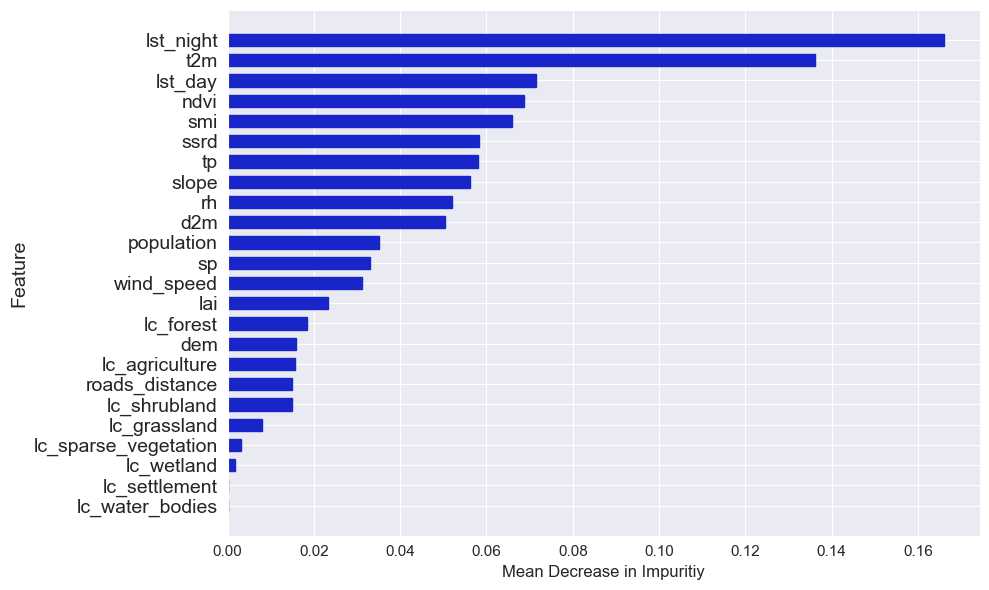

In [10]:
top24_sorted = top24.sort_values(by='Total_Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(top24_sorted['Variable'], top24_sorted['Total_Importance'], height=0.6, color='#1725C9', edgecolor='#1725C9')

plt.xlabel('Mean Decrease in Impuritiy', fontsize=12, fontweight='medium')
plt.ylabel('Feature', fontsize=14, fontweight='medium')
plt.gca().invert_yaxis()

plt.xticks(fontsize=11)
plt.yticks(fontsize=14)

plt.tight_layout()
plt.savefig('/Users/paulinebecker/Library/Mobile Documents/com~apple~CloudDocs/Uni/Wirtschaftsinformatik KIT/Semester6/Bachlorarbeit/Graphics/Results/RF_Feature_Importance', dpi=300)
plt.show()

In [17]:
top24

,Variable,Total_Importance
0,lst_night,0.1661
1,t2m,0.1361
2,lst_day,0.0714
3,ndvi,0.0686
4,smi,0.0659
5,ssrd,0.0582
6,tp,0.0580
7,slope,0.0562
8,rh,0.0521
9,d2m,0.0504


In [26]:
exclude_cols = ['sample', 'label', 'x', 'y']

shap_only = shap.drop(columns=exclude_cols)

shap_sum = shap_only.abs().sum(axis=0).reset_index()
shap_sum.columns = ['Variable', 'Total_Importance']
shap_sum

,Variable,Total_Importance
0,d2m,4.262831
1,dem,0.563069
2,lai,1.216568
3,lc_agriculture,0.915175
4,lc_forest,1.731191
5,lc_grassland,1.002604
6,lc_settlement,0.047177
7,lc_shrubland,1.303000
8,lc_sparse_vegetation,0.288571
9,lc_water_bodies,0.034492


In [ ]:
quartil = [0.1, 0.25, 0.5, 0.75, 0.95, 0.99]
for q in quartil:
    sum = 0
    i = 0
    while (sum + top24['Total_Importance'][i]) < q:
        sum +=  top24['Total_Importance'][i]
        i += 1
    print(f"{q*100}% der besten Feature durch {i} Features erreicht.")

for i in range(len(top24)):
    print(f"Variable {top24['Variable'][i]} hat eine Wichtigkeit von {top24['Total_Importance'][i]}")


In [12]:
def annotate_bars_stacked_vertical(ax, x, shap_1, shap_2, width):
    for i, (v1, v2) in enumerate(zip(shap_1, shap_2)):
        same_sign = np.sign(v1) == np.sign(v2)
        dx = 0.25

        if same_sign:
            if abs(v1) >= abs(v2):
                top_val, bot_val = v1, v2
                top_color, bot_color = "navy", "darkred"
                top_dx, bot_dx = -dx, +dx
            else:
                top_val, bot_val = v2, v1
                top_color, bot_color = "darkred", "navy"
                top_dx, bot_dx = +dx, -dx

            direction = np.sign(top_val)

            offset_top = 0.008 + 0.025 * abs(top_val)
            offset_between = 0.008

            y_top = top_val + offset_top if direction > 0 else top_val - offset_top
            y_bot = y_top - offset_between if direction > 0 else y_top + offset_between
            va = 'bottom' if direction > 0 else 'top'

            ax.text(x[i] + top_dx, y_top, f"{top_val:.2f}", ha='center', va=va, fontsize=8, color=top_color)
            ax.text(x[i] + bot_dx, y_bot, f"{bot_val:.2f}", ha='center', va=va, fontsize=8, color=bot_color)

        else:
            for val, dx_sign, color in zip([v1, v2], [-width/2, +width/2], ["navy", "darkred"]):
                offset = 0.002 + 0.05 * abs(val)
                y_pos = val + offset if val >= 0 else val - offset
                va = 'bottom' if val >= 0 else 'top'
                ax.text(x[i] + dx_sign, y_pos, f"{val:.2f}", ha='center', va=va, fontsize=8, color=color)


In [44]:
#csv data is created from waterfall method in plot_shap.py
def plot_grouped_shap_comparison_sorted(df_1, df_2):

    assert all(df_1['feature'] == df_2['feature']), "Features in den CSVs stimmen nicht überein."

    abs_sum_1 = df_1['shap_value'].sum()
    abs_sum_2 = df_2['shap_value'].sum()

    df_1['diff'] = (df_1['shap_value'] - df_2['shap_value']).abs()
    df_sorted = df_1.sort_values(by="diff", ascending=False).head(15).reset_index(drop=True) #.head(10)

    features = ["Total"] + df_sorted['feature'].tolist()
    shap_1 = [abs_sum_1] + df_1.set_index('feature').loc[df_sorted['feature'], 'shap_value'].tolist()
    shap_2 = [abs_sum_2] + df_2.set_index('feature').loc[df_sorted['feature'], 'shap_value'].tolist()

    x = np.arange(len(features))
    width = 0.35

    fig, ax = plt.subplots(figsize=(12, 10))

    #norm = plt.Normalize(min(shap_1 + shap_2), max(shap_1 + shap_2))
    #colors_1 = cm.Blues_r(norm(shap_1))
    #colors_2 = cm.Reds(norm(shap_2))

    norm = Normalize(0, max(np.abs(shap_1 + shap_2)))
    colors_1 = [cm.Blues(0.4 + 0.7 * norm(abs(val))) for val in shap_1]
    colors_2 = [cm.Reds(0.4 + 0.7 * norm(abs(val))) for val in shap_2]

    bars1 = ax.bar(x - width/2, shap_1, width, color=colors_1, label="Spain 15.06.2022")
    bars2 = ax.bar(x + width/2, shap_2, width, color=colors_2, label="Spain 17.07.2022")

    annotate_bars_stacked_vertical(ax, x, shap_1, shap_2, width)


    ax.set_ylabel("SHAP value", fontsize=14, fontweight='medium')
    ax.tick_params(axis='y', labelsize=12)
    ax.set_xticks(x)
    ax.set_xticklabels(features, rotation=45, fontsize=14, ha="right", fontweight='medium')
    ax.legend(title="Samples", fontsize=14)
    ax.axhline(0, color='black', linewidth=0.8)
    ax.set_ylim(-0.25, 0.2)
    ax.yaxis.set_major_locator(MultipleLocator(0.05))

    plt.tight_layout()
    #plt.savefig('/Users/paulinebecker/Library/Mobile Documents/com~apple~CloudDocs/Uni/Wirtschaftsinformatik KIT/Semester6/Bachlorarbeit/Graphics/Results/Case_studies/Transformer_SHAP_Two_Spain_grouped.png', dpi=300)
    plt.show()

In [58]:
def normalize_series_minmax(series):
    return (series - series.min()) / (series.max() - series.min())


def plot_grouped_importance_comparison_sorted(df_shap, df_rf, label_shap="SHAP", label_rf="Random Forest"):
    df_shap = df_shap.rename(columns={'Variable': 'feature', 'Total_Importance': 'shap_value'})
    df_rf = df_rf.rename(columns={'Variable': 'feature', 'Total_Importance': 'rf_value'})

    merged = pd.merge(df_shap, df_rf, on='feature', how='inner')

    merged['shap_value'] = normalize_series_minmax(merged['shap_value'])
    merged['rf_value'] = normalize_series_minmax(merged['rf_value'])

    df_sorted = merged.sort_values(by='shap_value', ascending=False).head(24).reset_index(drop=True)

    features = df_sorted['feature'].tolist()
    shap_vals = df_sorted['shap_value'].tolist()
    rf_vals = df_sorted['rf_value'].tolist()

    x = np.arange(len(features))
    width = 0.35

    fig, ax = plt.subplots(figsize=(14, 8))

    norm = Normalize(0, max(shap_vals + rf_vals))

    blau_cmap = LinearSegmentedColormap.from_list("blauviolett", ["#eff3ff", "#6a51a3"])

    tuerkis_cmap = LinearSegmentedColormap.from_list("tuerkis", ["#16C1E5", "#005f73"]) #c6f6f6

    colors_1 = [blau_cmap(0.4 + 0.6 * norm(abs(val))) for val in shap_vals]
    colors_2 = [tuerkis_cmap(0.4 + 0.6 * norm(abs(val))) for val in rf_vals]
    
    colors_shap = [Blues(0.4 + 0.6 * norm(val)) for val in shap_vals]
    colors_rf = [Reds(0.4 + 0.6 * norm(val)) for val in rf_vals]

    bars1 = ax.bar(x - width/2, shap_vals, width, color=colors_1, label=label_shap)
    bars2 = ax.bar(x + width/2, rf_vals, width, color=colors_2, label=label_rf)

    ax.set_ylabel("Total Importance", fontsize=14, fontweight='medium')
    ax.tick_params(axis='y', labelsize=12)
    ax.set_xticks(x)
    ax.set_xticklabels(features, rotation=45, fontsize=13, ha="right", fontweight='medium')
    ax.legend(title="XAI Method", fontsize=14, title_fontsize=14)
    ax.axhline(0, color='black', linewidth=0.8)
    plt.tight_layout()
    plt.savefig('/Users/paulinebecker/Library/Mobile Documents/com~apple~CloudDocs/Uni/Wirtschaftsinformatik KIT/Semester6/Bachlorarbeit/Graphics/Results/RF_SHAP_Importance_Comparison1.png', dpi=300)
    plt.show()


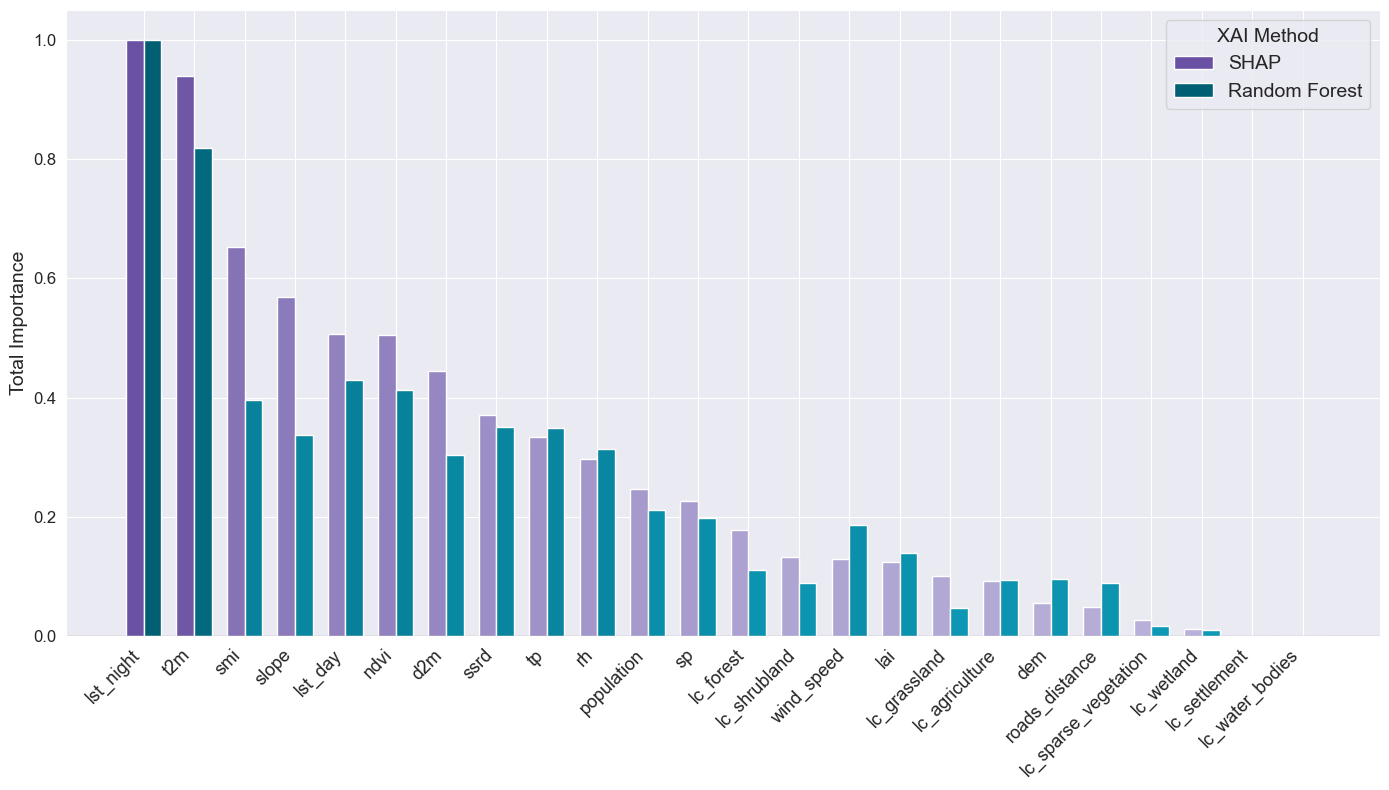

In [59]:
plot_grouped_importance_comparison_sorted(shap_sum, top24)

In [60]:
def normalize_series_minmax(series):
    return (series - series.min()) / (series.max() - series.min())

def plot_grouped_importance_comparison_sorted_by_difference(df_shap, df_rf, label_shap="SHAP", label_rf="Random Forest"):
    df_shap = df_shap.rename(columns={'Variable': 'feature', 'Total_Importance': 'shap_value'})
    df_rf = df_rf.rename(columns={'Variable': 'feature', 'Total_Importance': 'rf_value'})

    merged = pd.merge(df_shap, df_rf, on='feature', how='inner')
    merged['shap_value'] = normalize_series_minmax(merged['shap_value'])
    merged['rf_value'] = normalize_series_minmax(merged['rf_value'])

    merged['diff'] = (merged['shap_value'] - merged['rf_value']).abs()
    df_sorted = merged.sort_values(by='diff', ascending=False).head(24).reset_index(drop=True)

    features = df_sorted['feature'].tolist()
    shap_vals = df_sorted['shap_value'].tolist()
    rf_vals = df_sorted['rf_value'].tolist()

    x = np.arange(len(features))
    width = 0.35

    fig, ax = plt.subplots(figsize=(14, 8))

    norm = Normalize(0, max(shap_vals + rf_vals))

    blau_cmap = LinearSegmentedColormap.from_list("blauviolett", ["#eff3ff", "#6a51a3"])
    tuerkis_cmap = LinearSegmentedColormap.from_list("tuerkis", ["#16C1E5", "#005f73"])

    colors_1 = [blau_cmap(0.4 + 0.6 * norm(abs(val))) for val in shap_vals]
    colors_2 = [tuerkis_cmap(0.4 + 0.6 * norm(abs(val))) for val in rf_vals]

    bars1 = ax.bar(x - width/2, shap_vals, width, color=colors_1, label=label_shap)
    bars2 = ax.bar(x + width/2, rf_vals, width, color=colors_2, label=label_rf)

    ax.set_ylabel("Total Importance", fontsize=14, fontweight='medium')
    ax.tick_params(axis='y', labelsize=12)
    ax.set_xticks(x)
    ax.set_xticklabels(features, rotation=45, fontsize=13, ha="right", fontweight='medium')
    ax.legend(title="XAI Method", fontsize=14, title_fontsize=14)
    ax.axhline(0, color='black', linewidth=0.8)

    plt.tight_layout()
    plt.savefig('/Users/paulinebecker/Library/Mobile Documents/com~apple~CloudDocs/Uni/Wirtschaftsinformatik KIT/Semester6/Bachlorarbeit/Graphics/Results/RF_SHAP_Importance_Comparison_by_diff.png', dpi=300)
    plt.show()

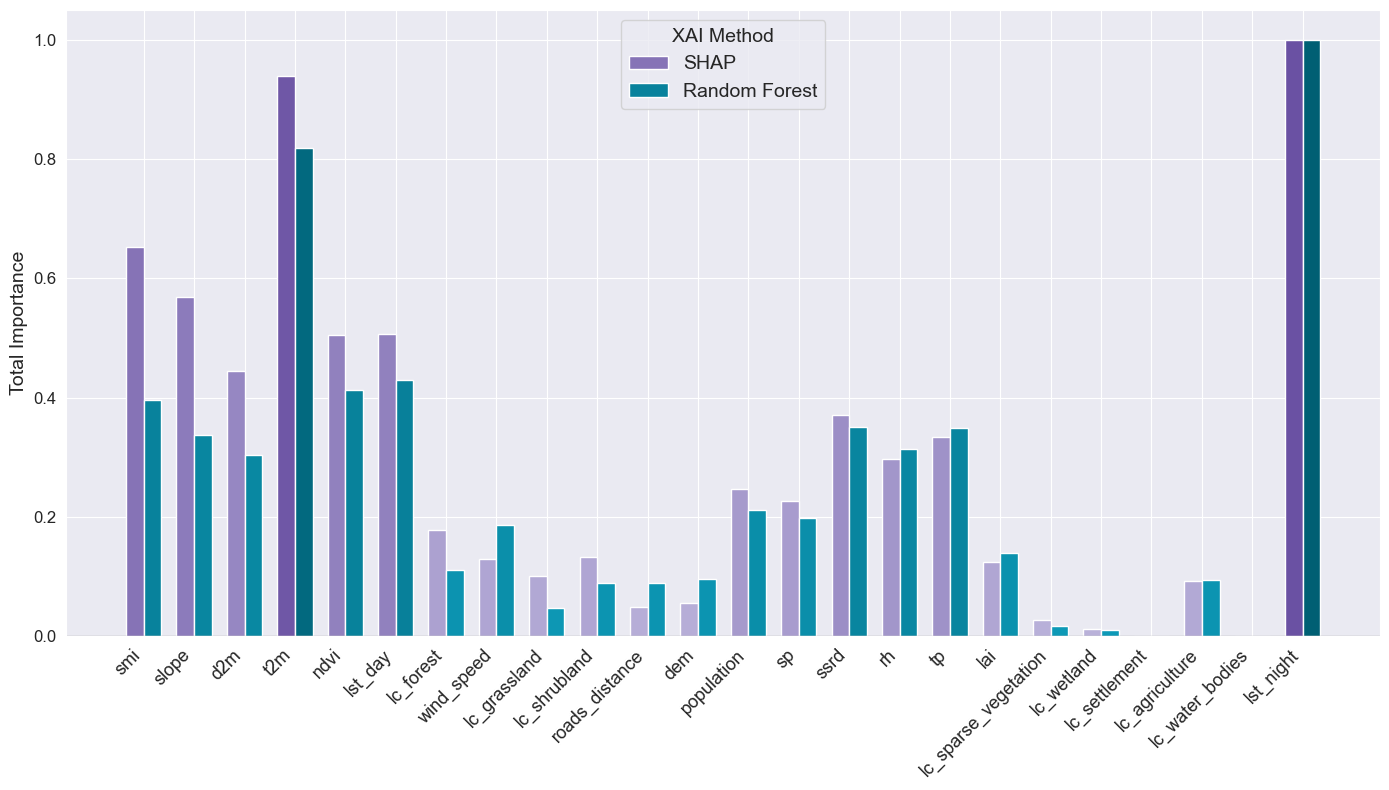

In [61]:
plot_grouped_importance_comparison_sorted_by_difference(shap_sum, top24)